<a href="https://colab.research.google.com/github/hduongck/AI-ML-Learning/blob/master/Excercise/Kaggle_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.makedirs("data/cancer",exist_ok=True)

#!pip install kaggle
!mkdir .kaggle

import json 
token = {"username":"hduongck","key":"983e2ab1fbb29cf2734bcbf8811d42fb"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
 
!chmod 600 /content/.kaggle/kaggle.json

!kaggle config set -n path -v{/content/data}

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle competitions download -c histopathologic-cancer-detection -p /content/data/cancer



Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 6, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 116, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
  0% 0.00/1.33M [00:00<?, ?B/s]
100% 1.33M/1.33M [00:00<00:00, 44.0MB/s]
  0% 0.00/5.10M [00:00<?, ?B/s]
100% 5.10M/5.10M [00:00<00:00, 83.4MB/s]
 98% 1.28G/1.30G [00:09<00:00, 151MB/s]
100% 1.30G/1.30G [00:10<00:00, 139MB/s]
100% 4.97G/4.98G [00:59<00:00, 62.2MB/s]
100% 4.98G/4.98G [00:59<00:00, 90.5MB/s]


In [0]:
from fastai.vision import *

In [0]:
for folder in ['train','test']:
    
    !unzip -qq /content/data/cancer/'{folder}'.zip -d data/cancer/'{folder}'

In [0]:
path ='/content/data/cancer/'

In [0]:
!unzip -qq /content/data/cancer/train_labels.csv.zip -d data/cancer/label

In [0]:
df = pd.read_csv(f'{path}/label/train_labels.csv')

In [7]:
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [0]:
tfms = get_transforms(max_rotate=20,max_zoom=1.3, max_lighting=0.4,
                    max_warp=0.4,p_affine=1., p_lighting=1.)

In [0]:
data = (ImageList.from_csv(path,'label/train_labels.csv',folder='train',suffix='.tif')
       .split_by_rand_pct(0.1)
       .label_from_df()
       .transform(get_transforms(),size=128,padding_mode='reflection')
       .databunch()).normalize(imagenet_stats)

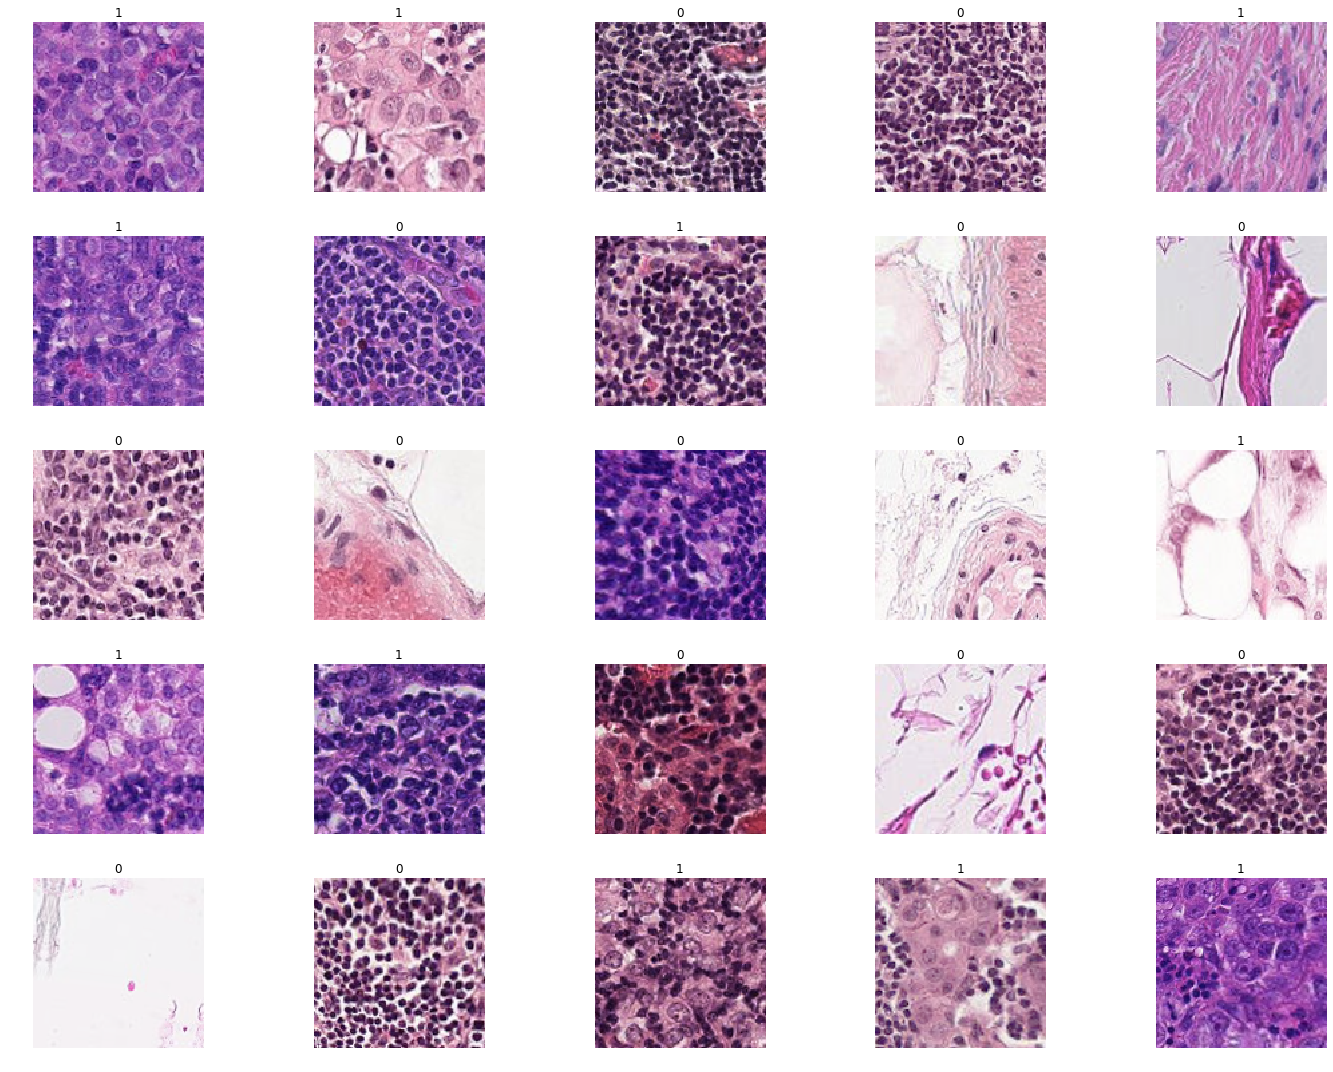

In [13]:
data.show_batch(row=2,figsize=(20,15))

In [14]:
data.classes

[0, 1]

In [15]:
learn = cnn_learner(data,models.resnet34,metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 57465285.44it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


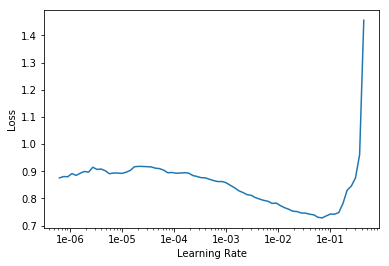

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(5,1e-03)

epoch,train_loss,valid_loss,error_rate,time
0,0.234301,0.203552,0.075857,12:59
1,0.196640,0.166177,0.062358,12:08
2,0.172940,0.139556,0.049814,12:05
3,0.166565,0.126878,0.045178,12:06
4,0.153194,0.125447,0.045223,11:48


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [20]:
learn.fit_one_cycle(5,max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.149647,0.121772,0.041678,12:29
1,0.148602,0.113510,0.039633,12:35
2,0.137482,0.104013,0.035406,12:33
3,0.123766,0.099391,0.034133,12:46
4,0.106947,0.096541,0.032679,12:43


In [0]:
learn.save('stage-2')

In [0]:
learn.export()

#Interprete the result

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

## plot top losses

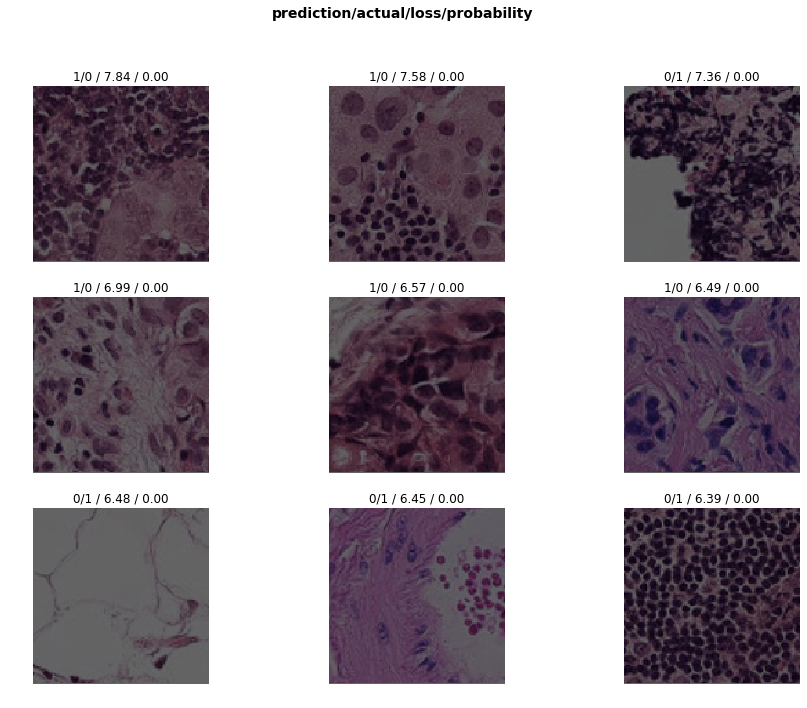

In [24]:
interp.plot_top_losses(9,figsize=(15,11))

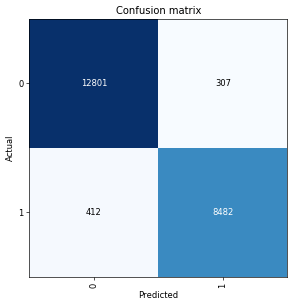

In [26]:
interp.plot_confusion_matrix(figsize=(5,5),dpi=60)

#Using Resnet50

In [28]:
gc.collect()

18148

In [27]:
learn = cnn_learner(data,models.resnet50,metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:05<00:00, 18671537.37it/s]


In [29]:
learn.fit_one_cycle(5,max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.323971,0.276366,0.115353,14:21
1,0.261562,0.231252,0.092264,14:16
2,0.248971,0.203800,0.081129,14:06
3,0.215212,0.198426,0.079311,14:18
4,0.239195,0.186678,0.074039,14:11


In [30]:
learn.fit_one_cycle(10,max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.234408,0.186829,0.073493,13:47
1,0.228873,0.183304,0.071312,13:42
2,0.228379,0.180760,0.070494,13:36
3,0.203176,0.171189,0.066403,13:47
4,0.203495,0.165765,0.061949,13:38
5,0.198221,0.158902,0.059949,13:33
6,0.197007,0.153483,0.056631,13:32
7,0.207643,0.153582,0.057404,13:36
8,0.188992,0.153026,0.057404,13:39
9,0.184448,0.153261,0.057813,13:36


In [0]:
learn.unfreeze()

In [32]:
learn.fit_one_cycle(5,max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.170597,0.151341,0.053222,14:53
1,0.144203,0.117408,0.040678,14:46
2,0.111563,0.091732,0.030634,14:38
3,0.083508,0.078710,0.026452,14:15
4,0.069860,0.070272,0.023271,14:16


In [33]:
learn.fit_one_cycle(5,max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.094570,0.084063,0.028679,14:21
1,0.108054,0.090831,0.031452,14:25
2,0.077601,0.083814,0.025679,14:59
3,0.066260,0.064178,0.020089,15:01
4,0.052137,0.063903,0.019544,14:58


In [0]:
learn.save('stage-3')

In [0]:
learn.export()

#Make submission file

In [0]:
test = ImageList.from_folder(f'{path}test')

In [0]:
learn = load_learner(path,test=test)

In [0]:
log_preds,_ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
preds=np.argmax(log_preds,axis=1)


In [45]:
log_preds[:10]

tensor([[8.2499e-05, 9.9992e-01],
        [2.5449e-02, 9.7455e-01],
        [9.9913e-01, 8.7242e-04],
        [1.0000e+00, 1.0735e-09],
        [9.9999e-01, 1.0107e-05],
        [1.4354e-03, 9.9856e-01],
        [1.0000e+00, 1.0253e-06],
        [6.9922e-03, 9.9301e-01],
        [1.4677e-03, 9.9853e-01],
        [9.9963e-01, 3.7009e-04]])

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [0]:
df_sub = pd.DataFrame({'id':fnames,'label':preds},columns=['id','label'])

In [43]:
df_sub.head()

,id,label
0,c237a3d8b586c610aa684ac4230b049ff92d9c58,1
1,21219e274e3ade6059d14c586a3e58f11ae1ef94,1
2,2af56e0be2d12a784c774bfc80e2cac21f125738,0
3,991d3e918189161ba2c9ef4666ff6efa958b5d2b,0
4,be61c95f1ccd21039280c3ddd572fd3dff052fff,0


In [0]:
df_sub.to_csv(f'{path}submission.csv',index=False)

In [0]:
!unzip -qq /content/data/cancer/sample_submission.csv.zip -d data/cancer/

In [0]:
sample = pd.read_csv(f'{path}sample_submission.csv')

In [0]:
sample.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [0]:
learn.data.classes

[0, 1]